In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Generate 10,000 student IDs
n_students = 10000
student_ids = [f'STU{i:05d}' for i in range(1, n_students+1)]

# Generate synthetic data with more meaningful features
data = {
    'student_id': student_ids,
    'name': [f'Student_{i}' for i in range(1, n_students+1)],
    'gender': np.random.choice(['M', 'F'], size=n_students, p=[0.55, 0.45]),
    'age': np.random.randint(16, 21, size=n_students),
    'socioeconomic_status': np.random.choice(['Low', 'Middle', 'High'], size=n_students, p=[0.3, 0.5, 0.2]),
    'previous_academic_score': np.random.normal(75, 15, n_students),  # Mean 75, Std 15
    'distance_from_school_km': np.random.exponential(5, n_students),  # Most live within 5km
    'attendance_rate': np.random.normal(0.85, 0.15, n_students),      # Mean 85%, Std 15%
    'avg_test_score': np.random.normal(65, 20, n_students),           # Mean 65%, Std 20
    'fee_default_rate': np.random.uniform(0, 1, n_students),          # % of fees unpaid
    'extracurricular_participation': np.random.choice(['None', 'Low', 'Medium', 'High'],
                                                     size=n_students, p=[0.4, 0.3, 0.2, 0.1]),
    'mentor_id': [f'MENT{np.random.randint(1, 51):03d}' for _ in range(n_students)],
}

# Create DataFrame
students_df = pd.DataFrame(data)

# Create target variable with meaningful correlations
students_df['is_active'] = 1  # Default to active

# Create dropout patterns based on features
dropout_conditions = (
    (students_df['attendance_rate'] < 0.7) |
    (students_df['avg_test_score'] < 50) |
    (students_df['fee_default_rate'] > 0.8) |
    (students_df['socioeconomic_status'] == 'Low') |
    (students_df['distance_from_school_km'] > 10)
)

students_df.loc[dropout_conditions, 'is_active'] = 0

# Add some noise (not all at-risk students drop out, some good students do)
mask = np.random.random(n_students) < 0.05  # Flip 5% of labels
students_df.loc[mask, 'is_active'] = 1 - students_df.loc[mask, 'is_active']

print("Dataset created successfully!")
print(f"Total samples: {len(students_df)}")
print(f"Active students: {students_df['is_active'].sum()}")
print(f"Dropout students: {len(students_df) - students_df['is_active'].sum()}")
print(f"Dropout rate: {(1 - students_df['is_active'].mean())*100:.2f}%")
students_df

Dataset created successfully!
Total samples: 10000
Active students: 3392
Dropout students: 6608
Dropout rate: 66.08%


,student_id,name,gender,age,socioeconomic_status,previous_academic_score,distance_from_school_km,attendance_rate,avg_test_score,fee_default_rate,extracurricular_participation,mentor_id,is_active
0,STU00001,Student_1,M,19,Middle,54.167349,1.962420,0.499422,73.071637,0.035312,Low,MENT009,0
1,STU00002,Student_2,F,17,Middle,88.128225,8.646887,0.469969,33.986322,0.009888,None,MENT001,0
2,STU00003,Student_3,F,20,High,57.760814,8.804727,0.741597,84.293653,0.586623,High,MENT015,1
3,STU00004,Student_4,F,18,High,84.122429,22.068399,0.902185,80.142781,0.521593,None,MENT023,0
4,STU00005,Student_5,M,18,Middle,70.438498,1.262142,0.690330,56.659142,0.696369,None,MENT017,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,STU09996,Student_9996,F,20,Low,66.060655,5.229981,0.913478,84.704701,0.054561,None,MENT026,0
9996,STU09997,Student_9997,F,16,Middle,57.182050,8.284408,0.848404,82.368918,0.912358,None,MENT049,0
9997,STU09998,Student_9998,F,16,Low,74.589392,2.837678,0.793362,69.707413,0.228600,None,MENT033,0
9998,STU09999,Student_9999,M,17,High,37.053034,8.841513,0.989100,50.728091,0.473188,Low,MENT023,1


In [45]:
# DATA PREPROCESSING
print("\n" + "="*50)
print("DATA PREPROCESSING")
print("="*50)

# Drop columns that won't be used in modeling
df_processed = students_df.drop(['student_id', 'name', 'mentor_id'], axis=1)

# Handle categorical variables
categorical_cols = ['gender', 'socioeconomic_status', 'extracurricular_participation']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
    print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Separate features and target
X = df_processed.drop('is_active', axis=1)
y = df_processed['is_active']

# Check for missing values
print(f"\nMissing values:\n{X.isnull().sum()}")




DATA PREPROCESSING
Encoded gender: {'F': np.int64(0), 'M': np.int64(1)}
Encoded socioeconomic_status: {'High': np.int64(0), 'Low': np.int64(1), 'Middle': np.int64(2)}
Encoded extracurricular_participation: {'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2), 'None': np.int64(3)}

Missing values:
gender                           0
age                              0
socioeconomic_status             0
previous_academic_score          0
distance_from_school_km          0
attendance_rate                  0
avg_test_score                   0
fee_default_rate                 0
extracurricular_participation    0
dtype: int64


In [46]:
# TRAIN-TEST SPLIT
print("\n" + "="*50)
print("TRAIN-TEST SPLIT")
print("="*50)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training dropout rate: {1 - y_train.mean():.3f}")
print(f"Test dropout rate: {1 - y_test.mean():.3f}")



TRAIN-TEST SPLIT
Training set size: 8000
Test set size: 2000
Training dropout rate: 0.661
Test dropout rate: 0.661


In [47]:
# FEATURE SCALING
print("\n" + "="*50)
print("FEATURE SCALING")
print("="*50)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

# HANDLE IMBALANCED DATA
print("\n" + "="*50)
print("HANDLING IMBALANCED DATA")
print("="*50)

print("Before SMOTE:")
print(f"Class 0 (Dropout) count: {sum(y_train == 0)}")
print(f"Class 1 (Active) count: {sum(y_train == 1)}")

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("\nAfter SMOTE:")
print(f"Class 0 (Dropout) count: {sum(y_train_balanced == 0)}")
print(f"Class 1 (Active) count: {sum(y_train_balanced == 1)}")




FEATURE SCALING
Features scaled using StandardScaler
Training set shape: (8000, 9)
Test set shape: (2000, 9)

HANDLING IMBALANCED DATA
Before SMOTE:
Class 0 (Dropout) count: 5286
Class 1 (Active) count: 2714

After SMOTE:
Class 0 (Dropout) count: 5286
Class 1 (Active) count: 5286


In [50]:
# MODEL TRAINING
print("\n" + "="*50)
print("MODEL TRAINING")
print("="*50)

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True)
}

trained_models = {}
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Use balanced data for training
    if name in ['Logistic Regression', 'SVM']:
        # These models benefit from scaled data
        model.fit(X_train_balanced, y_train_balanced)
    else:
        model.fit(X_train_balanced, y_train_balanced)

    trained_models[name] = model

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    results[name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    if roc_auc is not None:
        print(f"  ROC-AUC: {roc_auc:.4f}")



MODEL TRAINING

Training Random Forest...
  Accuracy: 0.9445
  F1-Score: 0.9157
  ROC-AUC: 0.9357

Training Gradient Boosting...
  Accuracy: 0.9455
  F1-Score: 0.9174
  ROC-AUC: 0.9361

Training Logistic Regression...
  Accuracy: 0.6710
  F1-Score: 0.5814
  ROC-AUC: 0.7491

Training SVM...
  Accuracy: 0.8905
  F1-Score: 0.8432
  ROC-AUC: 0.9260



MODEL EVALUATION

Model Performance Comparison:
                 Model  Accuracy  F1-Score   ROC-AUC
1    Gradient Boosting    0.9455  0.917362  0.936063
0        Random Forest    0.9445  0.915718  0.935722
3                  SVM    0.8905  0.843236  0.926024
2  Logistic Regression    0.6710  0.581425  0.749140

Detailed report for best model (Gradient Boosting):
              precision    recall  f1-score   support

     Dropout       0.95      0.97      0.96      1322
      Active       0.94      0.89      0.92       678

    accuracy                           0.95      2000
   macro avg       0.95      0.93      0.94      2000
weighted avg       0.95      0.95      0.95      2000



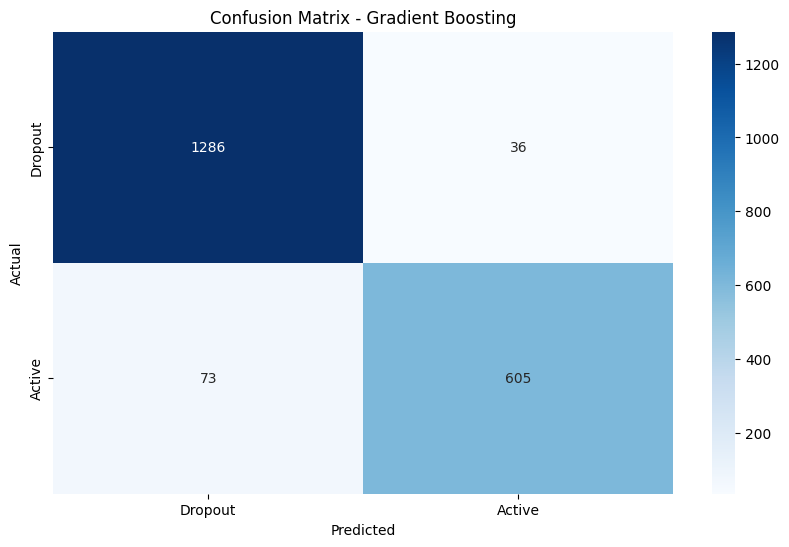

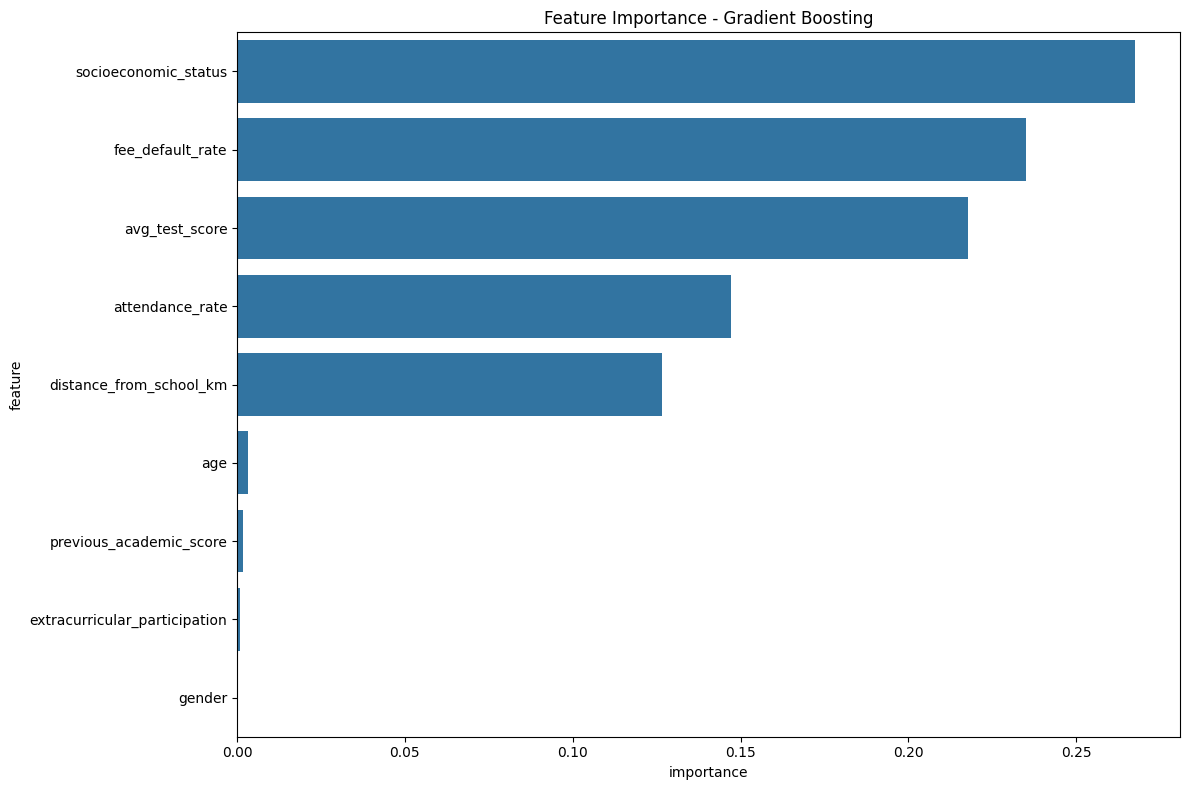


Model and preprocessing artifacts saved as 'student_dropout_model.pkl'


In [51]:
# MODEL EVALUATION
print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)

# Compare model performance
performance_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'F1-Score': [results[m]['f1_score'] for m in results],
    'ROC-AUC': [results[m]['roc_auc'] for m in results if results[m]['roc_auc'] is not None]
})

print("\nModel Performance Comparison:")
print(performance_df.sort_values('F1-Score', ascending=False))

# Detailed report for best model
best_model_name = performance_df.sort_values('F1-Score', ascending=False).iloc[0]['Model']
best_model = trained_models[best_model_name]

print(f"\nDetailed report for best model ({best_model_name}):")
print(classification_report(y_test, results[best_model_name]['predictions'],
                          target_names=['Dropout', 'Active']))

# Confusion Matrix for best model
plt.figure(figsize=(10, 6))
cm = confusion_matrix(y_test, results[best_model_name]['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dropout', 'Active'],
            yticklabels=['Dropout', 'Active'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature Importance for tree-based models
if hasattr(best_model, 'feature_importances_'):
    plt.figure(figsize=(12, 8))
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title(f'Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()

# Save the best model and preprocessing objects
import joblib

model_artifacts = {
    'model': best_model,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'feature_names': X.columns.tolist()
}

joblib.dump(model_artifacts, 'student_dropout_model.pkl')
print("\nModel and preprocessing artifacts saved as 'student_dropout_model.pkl'")

In [52]:
# Final validation on test set
print("\n" + "="*50)
print("FINAL VALIDATION RESULTS")
print("="*50)
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"Test F1-Score: {results[best_model_name]['f1_score']:.4f}")
print(f"Test ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")


FINAL VALIDATION RESULTS
Best Model: Gradient Boosting
Test Accuracy: 0.9455
Test F1-Score: 0.9174
Test ROC-AUC: 0.9361


In [3]:
# Load your trained model for real-time predictions
import joblib

def predict_dropout_risk(student_data):
    """Function to integrate with your dashboard"""
    model_artifacts = joblib.load('student_dropout_model.pkl')
    model = model_artifacts['model']
    scaler = model_artifacts['scaler']

    # Preprocess new data
    processed_data = preprocess_new_student(student_data, model_artifacts)
    scaled_data = scaler.transform(processed_data)

    # Make prediction
    prediction = model.predict(scaled_data)
    probability = model.predict_proba(scaled_data)[:, 1]

    return prediction, probability